# Processing raw data to combined data <br> 生データを結合したデータに加工する

# Load libraries ライブラリの読み込み

In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import math
import os
import sys

# Load configuration

In [2]:
# Participant to process
# 処理する参加者
USER = 'participant1'

# Collection dataset
# コレクションデータセット
# COLLECTION = '2-person'
COLLECTION = '10-person'

# Define train data path
# 訓練データのパスを定義
TRAIN_DATA_PATH = f'/workspaces/ABC Challenge 2023 train dataset/{COLLECTION}'

# Define test data path
# テストデータのパスを定義
TEST_DATA_PATH = '/workspaces/ABC Challenge 2023 test dataset'

# Desired interval 望ましい間隔
#   * 15min: 15 minutes
#   * 30min: 30 minutes
#   * 1h: 1 hour
#   * 15s: 15 seconds
TARGET_FREQ_AS_INT = 15     # 15|1
TARGET_FREQ_UNIT1 = 'min'   # min|s
TARGET_FREQ_UNIT2 = 'm'     # m|s
TARGET_FREQ = f'{TARGET_FREQ_AS_INT}{TARGET_FREQ_UNIT1}'

# Wearing-off columns for renaming where value is the output
# 出力値の場合のリネーム用のウェアリングオフカラム
WEARING_OFF_COLUMNS = {
  "Timestamp": "timestamp",
  "Wearing Off": "wearing_off",
  "started_at": "wo_start", "finished_at": "wo_end",
  "tremors": "wo_tremors",
  "slowdown": "wo_slowdown",
  "moodchange": "wo_moodchange",
  "rigidity": "wo_rigidity",
  "pain": "wo_pain",
  "impairment_hands": "wo_impairment_hands",
  "slow_thoughts": "wo_slow_thoughts",
  "anxiety": "wo_anxiety",
  "muscle_spasm": "wo_muscle_spasm"
}

# Drug intake columns for renaming where value is the output
# 出力値の場合のリネーム用の薬の摂取カラム
DRUG_INTAKE_COLUMNS = {
  "started_at": "drug_intake_start",
  "finished_at": "drug_intake_end",
  "tremors": "drug_intake_tremors",
  "slowdown": "drug_intake_slowdown",
  "moodchange": "drug_intake_moodchange",
  "rigidity": "drug_intake_rigidity",
  "pain": "drug_intake_pain",
  "impairment_hands": "drug_intake_impairment_hands",
  "slow_thoughts": "drug_intake_slow_thoughts",
  "anxiety": "drug_intake_anxiety",
  "muscle_spasm": "drug_intake_muscle_spasm"
}

# Define test periods
# テスト期間を定義
test_horizons = {
  "participant1": ["2021-12-02 0:00", "2021-12-03 23:45"],
  "participant2": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant3": ["2021-11-25 0:00", "2021-11-26 23:45"],
  "participant4": ["2021-12-06 0:00", "2021-12-07 7:15"],
  "participant5": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant6": ["2021-12-06 0:00", "2021-12-07 23:45"],
  "participant7": ["2021-12-12 0:00", "2021-12-13 9:45"],
  "participant8": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant9": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant10": ["2021-12-23 0:00", "2021-12-24 23:45"],
}

# Convert test periods to DataFrame
# テスト期間をDataFrameに変換
test_horizons_df = pd.DataFrame(
  [[participant, test_start_date, test_end_date]
   for participant, (test_start_date, test_end_date) in test_horizons.items()],
  columns=['participant', 'test_start_date', 'test_end_date']
)

# Load dataset データセットの読み込み

Load each datasets per participant for train and test sets <br>
それぞれの参加者のデータセットを読み込む.

Test sets have been truncated at intended forecast time to force forecast task <br>
テストセットは予測タスクを強制するために、予定された予測時間で切り捨てられています.

Wearing-off periods & Drug intake times does not have test sets <br>
Wearing-off periods & Drug intake times はテストセットがない.

In [3]:
heart_rate = pd.read_excel(f'{TRAIN_DATA_PATH}/garmin.xlsx',
                           sheet_name='heart_rate', index_col='Timestamp'
                           ).query(f'participant == "{USER}"')

heart_rate_test = pd.read_excel(f'{TEST_DATA_PATH}/garmin.xlsx',
                                sheet_name='heart_rate', index_col='Timestamp'
                                ).query(f'participant == "{USER}"')

In [4]:
steps = pd.read_excel(f'{TRAIN_DATA_PATH}/garmin.xlsx',
                      sheet_name='steps', index_col='Timestamp'
                      ).query(f'participant == "{USER}"')

steps_test = pd.read_excel(f'{TEST_DATA_PATH}/garmin.xlsx',
                           sheet_name='steps', index_col='Timestamp'
                           ).query(f'participant == "{USER}"')

In [5]:
stress = pd.read_excel(f'{TRAIN_DATA_PATH}/garmin.xlsx',
                       sheet_name='stress', index_col='Timestamp'
                       ).query(f'participant == "{USER}"')

stress_test = pd.read_excel(f'{TEST_DATA_PATH}/garmin.xlsx',
                            sheet_name='stress', index_col='Timestamp'
                            ).query(f'participant == "{USER}"')

In [6]:
sleep = pd.read_excel(f'{TRAIN_DATA_PATH}/garmin.xlsx',
                      sheet_name='sleep', index_col='Calendar Date'
                      ).query(f'participant == "{USER}"')

sleep_test = pd.read_excel(f'{TEST_DATA_PATH}/garmin.xlsx',
                           sheet_name='sleep', index_col='Calendar Date'
                           ).query(f'participant == "{USER}"')

In [7]:
wearing_off_periods = pd.read_excel(
  f'{TRAIN_DATA_PATH}/wearing_off_periods.xlsx',
  sheet_name='wearing_off_periods', index_col='wearing_off_id'
).query(
  f'participant == "{USER}"'
).drop(columns=['participant'])

In [8]:
drug_intake_with_symptoms = pd.read_excel(
  f'{TRAIN_DATA_PATH}/drug_intake_with_symptoms.xlsx',
  sheet_name='drug_intake_with_symptoms', index_col='drug_intake_id'
).query(
  f'participant == "{USER}"'
).drop(columns=['participant'])

# Resampling リサンプリング

There are two steps in resampling the dataset.
1. Complete reference dataframe w.r.t. to the collection period, dataset's interval.
2. Resample to desired interval e.g., 15-minute, 3-minute.

データセットのリサンプリングには2つのステップがあります.
1. コレクション期間、データセットの間隔に関して完全な参照データフレームを作成する.
2. 望ましい間隔(例えば15分、3分)にリサンプリングする.

## Complete reference dataframe <br> 完全な参照データフレーム
* Ensures equal spacing from the collection period's start and end date.
* Fills missing values according to how Garmin reports missing values.

* コレクション期間の開始日と終了日から等しい間隔を確保する.
* Garminが欠損値を報告する方法に従って欠損値を埋める.

### Heart rate 心拍数
* Fill missing values with -1, as per Garmin's documentation for missing values before resampling
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn
* Garminの欠損値に関するドキュメントに従って、欠損値をリサンプリング前に-1で埋める
* 予定された期間の欠損値は、Garmin vivosmart4が着用されていないことを示している

### Steps ステップ
* Fill missing values with -1 to standardize with other Garmin datasets
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn
* Garminの他のデータセットと標準化するために、欠損値を-1で埋める
* 予定された期間の欠損値は、Garmin vivosmart4が着用されていないことを示している

### Stress ストレス
* Fill missing values with -1, as per Garmin's documentation for missing values before resampling
* Missing values for the expected period indicate that the Garmin vivosmart4 was not worn
* Garminの欠損値に関するドキュメントに従って、欠損値をリサンプリング前に-1で埋める
* 予定された期間の欠損値は、Garmin vivosmart4が着用されていないことを示している

In [9]:
def complete_reference(df, target_column, set, freq='15s'):
  # Ensures the max date of train set is last available before test set
  # トレインセットの最大日付がテストセットの前に利用可能な最後の日付であることを確認します
  train_max_date = pd.to_datetime(
    test_horizons_df.query(
      f'participant == "{USER}"'
    ).test_start_date,
    format='%Y-%m-%d %H:%M'
  ) - pd.Timedelta(freq)

  # Ensures the min date of test set is the start of test set
  # テストセットの最小日付がテストセットの開始日であることを確認します
  test_min_date = pd.to_datetime(
    test_horizons_df.query(
      f'participant == "{USER}"'
    ).test_start_date,
    format='%Y-%m-%d %H:%M'
  )

  # Create reference dataframe based on the start date and end date.
  # 開始日と終了日に基づいて参照データフレームを作成します。
  if set == 'train':
    reference = pd.DataFrame(
      index=pd.date_range(
        start=df.index.min(),
        end=train_max_date.max(),
        freq=freq,
        name='Timestamp'
      )
    )
  elif set == 'test':
    reference = pd.DataFrame(
      index=pd.date_range(
        start=test_min_date.min(),
        end=df.index.max(),
        freq=freq,
        name='Timestamp'
      )
    )
  else:
    # Base case to get the min and max from the data
    # データから最小値と最大値を取得するためのベースケース
    reference = pd.DataFrame(
      index=pd.date_range(
        start=df.index.min(),
        end=df.index.max(),
        freq=freq,
        name='Timestamp'
      )
    )

  # Resample by dataset's interval
  #   Merge reference with heart rate data
  #   Fill missing values based on dataset's handling of missing values
  # データセットの間隔でリサンプリングします
  #   参照と心拍数データをマージします
  #   欠損値の処理に基づいて欠損値を埋めます
  df = reference.merge(
    df.resample(freq).agg({
      target_column: 'mean',
      'participant': 'first'
    }), on='Timestamp', how='left'
  ).fillna({
    target_column: -1,
    'participant': USER
  })
  return df


# Garmin's heart rate interval
# ガーミンの心拍数間隔
heart_rate_freq = '15s'
heart_rate = complete_reference(heart_rate,
                                target_column='heart_rate',
                                set='train',
                                freq=heart_rate_freq)
heart_rate_test = complete_reference(heart_rate_test,
                                     target_column='heart_rate',
                                     set='test',
                                     freq=heart_rate_freq)

# Garmin's step interval
# ガーミンのステップ間隔
steps_freq = '15min'
steps = complete_reference(steps,
                           target_column='steps',
                           set='train',
                           freq=steps_freq)
steps_test = complete_reference(steps_test,
                                target_column='steps',
                                set='test',
                                freq=steps_freq)

# Garmin's stress interval
# ガーミンのストレス間隔
stress_freq = '3min'
stress = complete_reference(stress,
                            target_column='stress_score',
                            set='train',
                            freq=stress_freq)
stress_test = complete_reference(stress_test,
                                 target_column='stress_score',
                                 set='test',
                                 freq=stress_freq)

### Sleep 睡眠

Transform sleep duration to sleep per day <br>
睡眠時間を1日あたりの睡眠時間に変換する

**Origin**
<!-- Generate a table for Markdown -->
| Date | Start | End | Sleep Stage |
| ---- | ----- | --- | ----------- |
2021-11-26 | 2021-11-26 01:17:00 | 2021-11-26 01:56:00 | light |
2021-11-26 | 2021-11-26 01:56:00 | 2021-11-26 01:58:00 | rem   |
2021-11-26 | 2021-11-26 01:58:00 | 2021-11-26 01:59:00 | light |

**Output**
| Timestamp  | awake | light | rem | deep | nonrem_total | total | nonrem_percentage | sleep_efficiency |
| ---------- | ----- | ----- | --- | ---- | ------------ | ----- | ----------------- | ---------------- |
| 2021-11-26 | 0 | 39 | 2 | 0 | 41 | 41 | 100.0 | 100.0 |

In [10]:
def transform_sleep_duration_to_sleep_per_day(df):
  # Compute duration in minutes
  # 分単位で期間を計算します
  df['duration'] = (df['End Time'] - df['Start Time']) / np.timedelta64(1, 'm')

  # Transform sleep data by sleep stage
  # 睡眠段階ごとに睡眠データを変換します
  df = df.pivot_table(
    index='Calendar Date',
    columns='Sleep Type',
    values='duration',
    aggfunc='sum'
  )

  # Fill missing sleep stage with 0 minutes
  # 欠損している睡眠段階を0分で埋めます
  df = pd.DataFrame(df.to_records(),
                    columns=['Calendar Date',
                             'awake', 'light',
                             'rem', 'deep']
                    ).set_index('Calendar Date').fillna(0)

  # Set index as DateTimeIndex type
  # インデックスをDateTimeIndex型に設定します
  df.index = pd.to_datetime(df.index)
  df.index.name = 'Timestamp'

  # Compute other sleep features
  # その他の睡眠機能を計算します
  df['nonrem_total'] = (df['deep'] + df['light'])
  df['total'] = (df['nonrem_total'] + df['rem'])
  df['nonrem_percentage'] = df['nonrem_total'] / df['total']
  df['sleep_efficiency'] = df['total'] / (df['total'] + df['awake'])

  # Ignore unmeasurable sleep classifcation
  # 測定不能な睡眠分類を無視します
  if 'unmeasurable' in df.columns:
    df.drop(columns='unmeasurable', inplace=True)

  return df


sleep = transform_sleep_duration_to_sleep_per_day(sleep)
sleep_test = transform_sleep_duration_to_sleep_per_day(sleep_test)

### Combine Garmin dataset <br> Garminデータセットの結合

Resample to desired interval e.g., 15-minute, 3-minute. <br>
Fill missing values due to resampling:
* Fill using previous known value.
* `ffill()` does this step.

望ましい間隔(例えば15分、3分)にリサンプリングする. <br>
リサンプリングによる欠損値の埋め合わせ:
* 以前の既知の値を使用して埋める.
* `ffill()` がこのステップを行う.


In [11]:
# Train Set
# 訓練セット
start = [heart_rate.index.min(),
         steps.index.min(),
         stress.index.min(),
         sleep.index.min()]

end = [heart_rate.index.max(),
       steps.index.max(),
       stress.index.max(),
       sleep.index.max()]

# Get minimum and maximum date from start
# 開始日から最小日と最大日を取得します
start = min(start)
end = max(end)

print("Check min and max value from train set")
print(f"min date: {start}")
print(
  f'Heart rate: {heart_rate.index.min()}\n',
  f'Steps: {steps.index.min()}\n',
  f'Stress: {stress.index.min()}\n',
  f'Sleep: {sleep.index.min()}\n',
)

print(f"max date: {end}")
print(
  f'Heart rate: {heart_rate.index.max()}\n',
  f'Steps: {steps.index.max()}\n',
  f'Stress: {stress.index.max()}\n',
  f'Sleep: {sleep.index.max()}\n',
)

Check min and max value from train set
min date: 2021-11-25 00:00:00
Heart rate: 2021-11-25 00:37:15
 Steps: 2021-11-25 00:00:00
 Stress: 2021-11-25 00:00:00
 Sleep: 2021-11-26 00:00:00

max date: 2021-12-01 23:59:45
Heart rate: 2021-12-01 23:59:45
 Steps: 2021-12-01 23:45:00
 Stress: 2021-12-01 23:57:00
 Sleep: 2021-12-01 00:00:00



In [12]:
# Test Set
# テストセット
start_test = [heart_rate_test.index.min(),
              steps_test.index.min(),
              stress_test.index.min(),
              sleep_test.index.min()]

end_test = [heart_rate_test.index.max(),
            steps_test.index.max(),
            stress_test.index.max(),
            sleep_test.index.max()]

# Get minimum and maximum date from start
# 開始日から最小日と最大日を取得します
start_test = min(start_test)
end_test = max(end_test)

print("Check min and max value from test set")
print(f"min date: {start_test}")
print(
  f'Heart rate: {heart_rate_test.index.min()}\n',
  f'Steps: {steps_test.index.min()}\n',
  f'Stress: {stress_test.index.min()}\n',
  f'Sleep: {sleep_test.index.min()}\n',
)

print(f"max date: {end_test}")
print(
  f'Heart rate: {heart_rate_test.index.max()}\n',
  f'Steps: {steps_test.index.max()}\n',
  f'Stress: {stress_test.index.max()}\n',
  f'Sleep: {sleep_test.index.max()}\n',
)

Check min and max value from test set
min date: 2021-12-02 00:00:00
Heart rate: 2021-12-02 00:00:00
 Steps: 2021-12-02 00:00:00
 Stress: 2021-12-02 00:00:00
 Sleep: 2021-12-02 00:00:00

max date: 2021-12-03 23:59:45
Heart rate: 2021-12-03 23:59:45
 Steps: 2021-12-03 23:45:00
 Stress: 2021-12-03 23:57:00
 Sleep: 2021-12-03 00:00:00



In [13]:
# Create reference dataframe based on train set's start date and end date.
# 訓練セットの開始日と終了日に基づいて参照データフレームを作成します。
reference = pd.DataFrame(
  index=pd.date_range(
    start=start,
    end=end,
    freq=TARGET_FREQ,
    name='Timestamp'
  )
)

# Combine each Garmin dataset to reference
#   * mean: get the average
#   * first: get the first value i.e., the value on that time
#   * last: get the last value i.e., the value on the previous time
# For example,
#   .resample(target_freq).agg({
#     'heart_rate': 'mean',
#   })
# 各Garminデータセットを結合して参照する
# 平均値を取得する
# * first: 最初の値、つまりその時刻の値を取得する。
# * last: 最後の値、つまり前の時刻の値を得る
# 例えば
# .resample(target_freq).agg({)
# 'heart_rate': 'mean'、
# })
garmin_data = reference.merge(
  # Resample heart rate (15sec) to target frequency (e.g., 15min)
  # 心拍数（15秒）をターゲット周波数（例：15分）にリサンプリングします
  heart_rate.resample(TARGET_FREQ).agg({
    'heart_rate': 'mean',
  }), on='Timestamp', how='left'
).ffill()

garmin_data = garmin_data.merge(
  # Resample steps (15min) to target frequency (e.g., 15min)
  # ステップ（15分）をターゲット周波数（例：15分）にリサンプリングします
  steps.resample(TARGET_FREQ).agg({
    'steps': 'mean',
  }), on='Timestamp', how='left'
).ffill()

garmin_data = garmin_data.merge(
  # Resample stress (3min) to target frequency (e.g., 15min)
  # ストレス（3分）をターゲット周波数（例：15分）にリサンプリングします
  stress.resample(TARGET_FREQ).agg({
    'stress_score': 'mean',
  }), on='Timestamp', how='left'
).ffill()

garmin_data = garmin_data.merge(
  # Resample sleep (1d) to target frequency (e.g., 15min)
  # 睡眠（1日）をターゲット周波数（例：15分）にリサンプリングします
  sleep.resample(TARGET_FREQ).mean(), on='Timestamp', how='left'
).ffill()

print(garmin_data.head(7).index)
print(garmin_data.tail(7).index)

DatetimeIndex(['2021-11-25 00:00:00', '2021-11-25 00:15:00',
               '2021-11-25 00:30:00', '2021-11-25 00:45:00',
               '2021-11-25 01:00:00', '2021-11-25 01:15:00',
               '2021-11-25 01:30:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)
DatetimeIndex(['2021-12-01 22:15:00', '2021-12-01 22:30:00',
               '2021-12-01 22:45:00', '2021-12-01 23:00:00',
               '2021-12-01 23:15:00', '2021-12-01 23:30:00',
               '2021-12-01 23:45:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)


In [14]:
# Create reference dataframe based on test set's start date and end date.
# テストセットの開始日と終了日に基づいて参照データフレームを作成します。
reference = pd.DataFrame(
  index=pd.date_range(
    start=start_test,
    end=end_test,
    freq=TARGET_FREQ,
    name='Timestamp'
  )
)

# Combine each Garmin dataset to reference
#   * mean: get the average
#   * first: get the first value i.e., the value on that time
#   * last: get the last value i.e., the value on the previous time
# For example,
#   .resample(target_freq).agg({
#     'heart_rate': 'mean',
#   })
# 各Garminデータセットを結合して参照する
# 平均値を取得する
# * first: 最初の値、つまりその時刻の値を取得する。
# * last: 最後の値、つまり前の時刻の値を得る
# 例えば
# .resample(target_freq).agg({)
# 'heart_rate': 'mean'、
# })
garmin_data_test = reference.merge(
  # Resample heart rate (15sec) to target frequency (e.g., 15min)
  # 心拍数（15秒）をターゲット周波数（例：15分）にリサンプリングします
  heart_rate_test.resample(TARGET_FREQ).agg({
    'heart_rate': 'mean',
  }), on='Timestamp', how='left'
).ffill()

garmin_data_test = garmin_data_test.merge(
  # Resample steps (15min) to target frequency (e.g., 15min)
  # ステップ（15分）をターゲット周波数（例：15分）にリサンプリングします
  steps_test.resample(TARGET_FREQ).agg({
    'steps': 'mean',
  }), on='Timestamp', how='left'
).ffill()

garmin_data_test = garmin_data_test.merge(
  # Resample stress (3min) to target frequency (e.g., 15min)
  # ストレス（3分）をターゲット周波数（例：15分）にリサンプリングします
  stress_test.resample(TARGET_FREQ).agg({
    'stress_score': 'mean',
  }), on='Timestamp', how='left'
).ffill()

garmin_data_test = garmin_data_test.merge(
  # Resample sleep (1d) to target frequency (e.g., 15min)
  # 睡眠（1日）をターゲット周波数（例：15分）にリサンプリングします
  sleep_test.resample(TARGET_FREQ).mean(), on='Timestamp', how='left'
).ffill()

print(garmin_data_test.head().index)
print(garmin_data_test.tail().index)

DatetimeIndex(['2021-12-02 00:00:00', '2021-12-02 00:15:00',
               '2021-12-02 00:30:00', '2021-12-02 00:45:00',
               '2021-12-02 01:00:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)
DatetimeIndex(['2021-12-03 22:45:00', '2021-12-03 23:00:00',
               '2021-12-03 23:15:00', '2021-12-03 23:30:00',
               '2021-12-03 23:45:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)


# Combine datasets <br> データセットの結合

## Match wearing-off periods with Garmin data <br> Garminデータとの着用時間の一致

In [15]:
# Train set
# 訓練セット

# Match wearing-off periods to garmin timestamp by left join
#   Left join when wearing-off period start and end time is between garmin timestamp
# 左結合により、着用オフ期間をガーミンタイムスタンプに一致させます
#   着用オフ期間の開始時刻と終了時刻がガーミンタイムスタンプの間にある場合は、左結合します
def pysqldf(q): return sqldf(q, globals())


cond_join = '''
  select 
    garmin.*,
    wearing_off_periods.*,
    case
      when wearing_off_periods.[started_at] is not null THEN 1
    else 0
    end as 'Wearing Off'
  from garmin_data as garmin
  left join wearing_off_periods
  on garmin.[Timestamp] BETWEEN
    wearing_off_periods.[started_at] AND wearing_off_periods.[finished_at]
'''

# Merge Garmin data with wearing off periods
#   Then, update columns
# ガーミンデータを着用オフ期間とマージします
#   それから、列を更新します
combined_data = pysqldf(cond_join).rename(columns=WEARING_OFF_COLUMNS)

# Drop duplicates based on timestamp
# タイムスタンプを基準に重複を削除します
combined_data.drop_duplicates(subset='timestamp', inplace=True)

# Set timestamp as index, of type DateTimeIndex
# タイムスタンプをインデックスとして設定します。DateTimeIndexのタイプ
combined_data.set_index('timestamp', inplace=True)
combined_data.index = pd.to_datetime(combined_data.index)

In [16]:
# Test set
# テストセット

# Since there is no available wearing-off periods,
#   copy Garmin data and apply same process as above
# 利用可能な着用オフ期間がないため、
#   ガーミンデータをコピーして、上記と同じプロセスを適用します
combined_data_test = garmin_data_test.copy().reset_index() \
  .rename(columns=WEARING_OFF_COLUMNS)

# Drop duplicates based on timestamp
# タイムスタンプを基準に重複を削除します
combined_data_test.drop_duplicates(subset='timestamp', inplace=True)

# Set timestamp as index, of type DateTimeIndex
# タイムスタンプをインデックスとして設定し、DateTimeIndexのタイプにします
combined_data_test.set_index('timestamp', inplace=True)
combined_data_test.index = pd.to_datetime(combined_data_test.index)

## Match drug intake time to combined data <br> 薬の服用時間を結合したデータに合わせる

**Note**: Since there is no drug intake for test set, skip for test set <br>
**注意**: テストセットには薬の服用がないため、テストセットはスキップする

In [17]:
# Train set
# 訓練セット


# Add TARGET_FREQ to the start date
#   to get the start and end date of the wearing off period
#   e.g., 15min -> 15min after
# 開始日にTARGET_FREQを追加します
#   着用オフ期間の開始日と終了日を取得するには
#   例：15分->後の15分
drug_intake_with_symptoms['started_at_after_buffer'] = (
  drug_intake_with_symptoms['started_at'] +
    np.timedelta64(TARGET_FREQ_AS_INT, TARGET_FREQ_UNIT2)
)


def pysqldf(q): return sqldf(q, globals())


cond_join = '''
  select 
    combined_data.*,
    drug_intake_with_symptoms.*,
    case
      when drug_intake_with_symptoms.[started_at] is not null THEN 1
    else 0
    end as 'drug_intake'
  from combined_data
  left join drug_intake_with_symptoms
  on combined_data.[timestamp] BETWEEN
  drug_intake_with_symptoms.[started_at] AND
    drug_intake_with_symptoms.[started_at_after_buffer]
'''

# Merge combined data with drug intake times
#   Then, update columns
# 薬物摂取時間と組み合わせたデータをマージします
#   それから、列を更新します
combined_data = pysqldf(cond_join).rename(columns=DRUG_INTAKE_COLUMNS)

# Drop duplicates based on timestamp
# タイムスタンプを基準に重複を削除します
combined_data.drop_duplicates(subset='timestamp', inplace=True)
combined_data.drop(
  columns=['started_at_after_buffer'],
  inplace=True)

# Set timestamp as index, of type DateTimeIndex
# タイムスタンプをインデックスとして設定します。DateTimeIndexのタイプ
combined_data.set_index('timestamp', inplace=True)
combined_data.index = pd.to_datetime(combined_data.index)

## Generate final symptoms <br> 最終的な症状を生成する

Initial symptoms + Symptoms after drug intake <br>
薬の服用後の初期症状 + 症状

In [18]:
wo_symptoms = ['wo_pain', 'wo_tremors', 'wo_anxiety', 'wo_rigidity',
               'wo_slowdown', 'wo_slow_thoughts', 'wo_impairment_hands',
               'wo_moodchange', 'wo_muscle_spasm']

drug_intake_symptoms = ['drug_intake_pain', 'drug_intake_tremors',
                        'drug_intake_anxiety', 'drug_intake_rigidity',
                        'drug_intake_slowdown', 'drug_intake_slow_thoughts',
                        'drug_intake_impairment_hands',
                        'drug_intake_moodchange', 'drug_intake_muscle_spasm']

symptoms = ['pain', 'tremors', 'anxiety', 'rigidity', 'slowdown', 'slow_thoughts',
            'impairment_hands', 'moodchange', 'muscle_spasm',
            'wearing_off_post_meds']


def generate_final_symptoms(row):
  """
  Generate a list of final symptoms based on the patient's symptoms.
  患者の症状に基づいて、最終的な症状のリストを生成します。
  """
  values = []
  for wo_symptom, drug_intake_symptom in zip(wo_symptoms, drug_intake_symptoms):
    # If the patient did not take medication, use the "without medication" symptom.
    # 患者が薬を服用しなかった場合は、「薬なし」の症状を使用します。
    if math.isnan(row[drug_intake_symptom]):
      if row[wo_symptom] is None or math.isnan(row[wo_symptom]):
        values.append(0)
      else:
        values.append(row[wo_symptom])
    # Otherwise, use the "after medication" symptom.
    # それ以外の場合は、「薬後」の症状を使用します。
    else:
      values.append(row[drug_intake_symptom])
  # Add the "wearing off" symptom if any of the symptoms are present.
  # 症状がいずれかある場合は、「着用オフ」の症状を追加します。
  if sum(values) >= 1:
    values.append(1)
  else:
    values.append(0)
  return pd.Series(values)

In [19]:
# Train set
# 訓練セット
final_symptoms = combined_data.apply(
  lambda row: generate_final_symptoms(row), axis=1
)

final_symptoms.columns = symptoms
combined_data = combined_data.merge(final_symptoms, on='timestamp', how='left')

## Generate final wearing-off <br> 最終的な着用時間を生成する

In [20]:
def combine_wearing_offs(n):
  '''
  Check if the sum of the symptoms is greater than 0.
  If so, return 1, else return 0.
  That means there is at least 1 symptom present.
  症状の合計が0より大きいかどうかを確認します。
  そうであれば、1を返します。そうでなければ0を返します。
  つまり、少なくとも1つの症状が存在することを意味します。
  '''
  if n > 0:
    return 1
  else:
    return 0

In [21]:
# TRAIN SET
combined_data["final_wearing_off"] = (
  combined_data.wearing_off + combined_data.wearing_off_post_meds
).apply(
  lambda n: combine_wearing_offs(n)
).values

In [22]:
display(
  combined_data.head(5)
)

display(
  combined_data.columns
)

,heart_rate,steps,stress_score,awake,light,rem,deep,nonrem_total,total,nonrem_percentage,...,tremors,anxiety,rigidity,slowdown,slow_thoughts,impairment_hands,moodchange,muscle_spasm,wearing_off_post_meds,final_wearing_off
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-11-25 00:00:00,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2021-11-25 00:15:00,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2021-11-25 00:30:00,43.419355,0.0,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2021-11-25 00:45:00,60.250000,0.0,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2021-11-25 01:00:00,10.600000,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Index(['heart_rate', 'steps', 'stress_score', 'awake', 'light', 'rem', 'deep',
       'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency',
       'wearing_off_id', 'wo_start', 'wo_end', 'wo_pain', 'wo_tremors',
       'wo_anxiety', 'wo_rigidity', 'wo_slowdown', 'wo_slow_thoughts',
       'wo_impairment_hands', 'wo_moodchange', 'wo_muscle_spasm',
       'wearing_off', 'drug_intake_id', 'drug_intake_start',
       'drug_intake_pain', 'drug_intake_tremors', 'drug_intake_anxiety',
       'drug_intake_rigidity', 'drug_intake_slowdown',
       'drug_intake_slow_thoughts', 'drug_intake_impairment_hands',
       'drug_intake_moodchange', 'drug_intake_muscle_spasm', 'drug_intake',
       'pain', 'tremors', 'anxiety', 'rigidity', 'slowdown', 'slow_thoughts',
       'impairment_hands', 'moodchange', 'muscle_spasm',
       'wearing_off_post_meds', 'final_wearing_off'],
      dtype='object')

# Post-Processing <br> ポストプロセッシング

## Compute for wearing-off duration <br> 着用期間を計算する

There are two options to process wearing-off duration:
* Compute wearing-off duration
* Compute wearing-off duration until the next reported wearing-off

着用期間の処理には、2つのオプションがあります：
* 装着期間計算
* 次に報告されるウェアリング・オフまでの期間を計算する。

### Option 1: Compute wearing-off duration <br> オプション1：着用期間を計算する
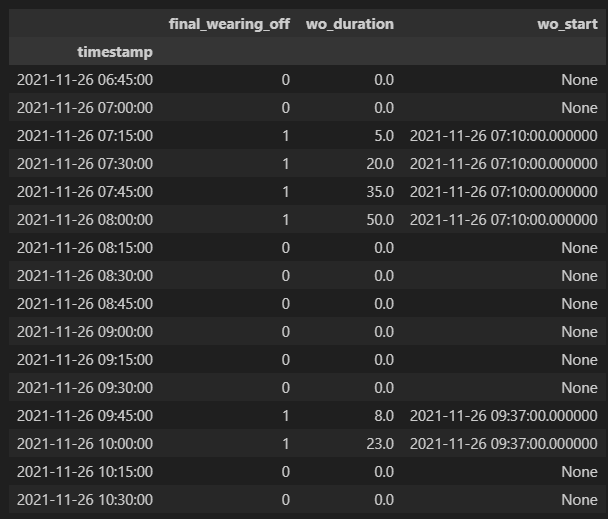

In [23]:
# Compute wearing-off duration only during wearing-off periods
# 着用オフ期間中の着用オフ期間のみを計算します

# TRAIN SET
# 訓練セット
combined_data['wo_duration'] = (
  pd.to_datetime(combined_data.index) -
  pd.to_datetime(combined_data['wo_start'])
) / np.timedelta64(1, TARGET_FREQ_UNIT2)
combined_data['wo_duration'] = combined_data['wo_duration'].fillna(0)

combined_data.loc[:, ['final_wearing_off',
                      'wo_duration', 'wo_start']].iloc[123:139]

,final_wearing_off,wo_duration,wo_start
timestamp,,,
2021-11-26 06:45:00,0,0.0,None
2021-11-26 07:00:00,0,0.0,None
2021-11-26 07:15:00,1,5.0,2021-11-26 07:10:00.000000
2021-11-26 07:30:00,1,20.0,2021-11-26 07:10:00.000000
2021-11-26 07:45:00,1,35.0,2021-11-26 07:10:00.000000
2021-11-26 08:00:00,1,50.0,2021-11-26 07:10:00.000000
2021-11-26 08:15:00,0,0.0,None
2021-11-26 08:30:00,0,0.0,None
2021-11-26 08:45:00,0,0.0,None


### Option 2: Compute wearing-off duration until the next reported wearing-off <br> オプション2：次に報告されるウェアリング・オフまでの期間を計算する。
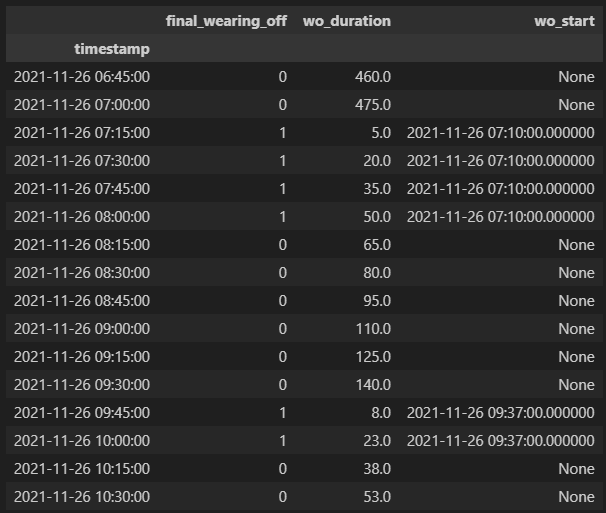

In [24]:
# # Compute wearing-off duration until the next reported wearing-off
# # 次に報告される着用オフまでの着用オフ期間を計算します

# # TRAIN SET
# # 訓練セット
# combined_data['wo_duration'] = (
#   pd.to_datetime(combined_data.index) -
#   pd.to_datetime(combined_data['wo_start'])
# ) / np.timedelta64(1, TARGET_FREQ_UNIT2)

# gid = combined_data['wo_duration'].notnull().cumsum()
# dg = combined_data.groupby(gid)
# base = dg['wo_duration'].transform('last')
# combined_data['wo_duration'] = (base + (dg.cumcount()) * TARGET_FREQ_AS_INT)

# combined_data.loc[:, ['final_wearing_off',
#                       'wo_duration', 'wo_start']].iloc[123:139]

## Compute time from last drug taken <br> 最後に服用した薬の時間を計算する

Find the difference between the **reference timestamp** & **drug intake start** <br>
参照タイムスタンプ**と**薬剤摂取開始**の差を調べる

In [25]:
# Compute time from last drug intake
# 最後の薬の服用からの時間を計算します

# TRAIN SET
# 訓練セット
combined_data['time_from_last_drug_taken'] = (
  pd.to_datetime(combined_data.index) -
  pd.to_datetime(combined_data['drug_intake_start'])
) / np.timedelta64(1, TARGET_FREQ_UNIT2)

# Then, fill records after drug intake report by adding target frequency
# 次に、ターゲット周波数を追加して、薬の服用報告後のレコードを埋めます
gid = combined_data['time_from_last_drug_taken'].notnull().cumsum()
dg = combined_data.groupby(gid)
base = dg['time_from_last_drug_taken'].transform('last')
combined_data['time_from_last_drug_taken'] = (
  base + (dg.cumcount()) * TARGET_FREQ_AS_INT)

if combined_data['time_from_last_drug_taken'].isna().any():
  combined_data['time_from_last_drug_taken'] = \
    combined_data['time_from_last_drug_taken'].fillna(0)

combined_data.loc[:, ['drug_intake_id', 'drug_intake_start',
                      'time_from_last_drug_taken']].iloc[40:70]

,drug_intake_id,drug_intake_start,time_from_last_drug_taken
timestamp,,,
2021-11-25 10:00:00,1023.0,2021-11-25 09:54:00.000000,6.0
2021-11-25 10:15:00,NaN,None,21.0
2021-11-25 10:30:00,NaN,None,36.0
2021-11-25 10:45:00,NaN,None,51.0
2021-11-25 11:00:00,1024.0,2021-11-25 11:00:00.000000,0.0
2021-11-25 11:15:00,1024.0,2021-11-25 11:00:00.000000,15.0
2021-11-25 11:30:00,NaN,None,30.0
2021-11-25 11:45:00,NaN,None,45.0
2021-11-25 12:00:00,NaN,None,60.0


## Include hour & day of the week <br> 時間と曜日を含める

In [26]:
# TRAIN SET
# 訓練セット
combined_data['timestamp_hour'] = combined_data.index.hour
combined_data['timestamp_dayofweek'] = combined_data.index.dayofweek

In [27]:
# TEST SET
# テストセット
combined_data_test['timestamp_hour'] = combined_data_test.index.hour
combined_data_test['timestamp_dayofweek'] = combined_data_test.index.dayofweek

## Encode hour-features as cyclical features <br> 時間特徴を循環特徴としてエンコードする

Include sine(hour) and cosine(hour) as features. <br>
特徴としてsine(hour)とcosine(hour)を含める

In [28]:
# TRAIN SET
# 訓練セット

# Fix timestamp format
# タイムスタンプ形式を修正する
date_time = pd.to_datetime(combined_data.index, format='%d.%m.%Y %H:%M:%S')

# Convert to timestamp
# タイムスタンプに変換する
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# Get seconds per day
# 1日あたりの秒数を取得する
day = 24 * 60 * 60
# Get seconds per year
# 1年あたりの秒数を取得する
year = 365.2425 * day

# Get sine(), cosine() for hour-feature
# hour-featureのsine()、cosine()を取得する
combined_data['timestamp_hour_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
combined_data['timestamp_hour_cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [29]:
# TEST SET
# テストセット

# Fix timestamp format
# タイムスタンプ形式を修正する
date_time = pd.to_datetime(combined_data_test.index, format='%d.%m.%Y %H:%M:%S')

# Convert to timestamp
# タイムスタンプに変換する
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# Get seconds per day
# 1日あたりの秒数を取得する
day = 24 * 60 * 60
# Get seconds per year
# 1年あたりの秒数を取得する
year = 365.2425 * day

# Get sine(), cosine() for hour-feature
# hour-featureのsine()、cosine()を取得する
combined_data_test['timestamp_hour_sin'] = np.sin(
    timestamp_s * (2 * np.pi / day))
combined_data_test['timestamp_hour_cos'] = np.cos(
    timestamp_s * (2 * np.pi / day))

# Save combined & processed dataset <br> 結合された処理済みデータセットを保存する

In [30]:
# Choose features 特徴量
# Garmin features Garminの特徴量
features = ['heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem',
            'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Additional features
# 追加の特徴量
features += ['timestamp_hour', 'timestamp_dayofweek',
             'timestamp_hour_sin', 'timestamp_hour_cos']

# Choices: wearing_off | wearing_off_post_meds | final_wearing_off
# 選択肢：wearing_off | wearing_off_post_meds | final_wearing_off
TARGET_COLUMN = 'final_wearing_off'
features.append(TARGET_COLUMN)

In [31]:
# Delete combined_data.xlsx if needed
# 必要に応じてcombined_data.xlsxを削除する

# for_saving_file = f'{TRAIN_DATA_PATH}/combined_data.xlsx'
# # Delete file for_saving_file whether exists or not
# os.remove(for_saving_file)

# for_saving_file = f'{TEST_DATA_PATH}/combined_data.xlsx'
# # Delete file for_saving_file whether exists or not
# os.remove(for_saving_file)

In [32]:
# TRAIN SET
# 訓練セット

# Select features to include
# 含める特徴量を選択する
for_saving = combined_data.loc[:, features].copy()

# Rename target column to 'wearing_off
# ターゲット列を「wearing_off」に名前を変更する
for_saving.rename(columns={
  TARGET_COLUMN: 'wearing_off'
}, inplace=True)

# Add back the participant column
# 参加者の列を追加する
for_saving['participant'] = USER

# Save combined dataset to file
#  If the Excel file exists, append to the existing file
#  If the Excel file does not exist, create a new file
# Excelファイルが存在する場合は、既存のファイルに追加します
#  Excelファイルが存在する場合は、既存のファイルに追記する
#  Excelファイルが存在しない場合は、新規にファイルを作成します。
for_saving_file = f'{TRAIN_DATA_PATH}/combined_data.xlsx'
if os.path.exists(for_saving_file):
  with pd.ExcelWriter(for_saving_file, mode='a', if_sheet_exists='overlay') as writer:
    for_saving.reset_index().to_excel(
      writer, sheet_name='combined_dataset',
      startrow=writer.sheets['combined_dataset'].max_row,
      header=None, index=False
    )
else:
  with pd.ExcelWriter(for_saving_file) as writer:
    for_saving.to_excel(writer, sheet_name='combined_dataset')

In [33]:
# TEST SET
# テストセット

# Select features to include
# 含める特徴量を選択する
combined_data_test[TARGET_COLUMN] = np.nan
combined_data_test = combined_data_test.reset_index().rename(
  columns={"Timestamp": "timestamp"}).set_index('timestamp')
for_saving = combined_data_test.loc[:, features].copy()

# Rename target column to 'wearing_off
# ターゲット列を「wearing_off」に名前を変更する
for_saving.rename(columns={
  TARGET_COLUMN: 'wearing_off'
}, inplace=True)

# Add back the participant column
# 参加者の列を追加する
for_saving['participant'] = USER

# Save combined dataset to file
#  If the Excel file exists, append to the existing file
#  If the Excel file does not exist, create a new file
# Excelファイルが存在する場合は、既存のファイルに追加します
#  Excelファイルが存在する場合は、既存のファイルに追記する
#  Excelファイルが存在しない場合は、新規にファイルを作成します。
for_saving_file = f'{TEST_DATA_PATH}/combined_data.xlsx'
if os.path.exists(for_saving_file):
  with pd.ExcelWriter(for_saving_file, mode='a', if_sheet_exists='overlay') as writer:
    for_saving.reset_index().to_excel(
      writer, sheet_name='combined_dataset',
      startrow=writer.sheets['combined_dataset'].max_row,
      header=None, index=False
    )
else:
  with pd.ExcelWriter(for_saving_file) as writer:
    for_saving.to_excel(writer, sheet_name='combined_dataset')